## Code Modules

In [1]:
import tensorflow_hub as th,tensorflow as tf
import numpy as np,pandas as pd,pylab as pl
from tensorflow.keras.datasets import mnist
import tensorflow.keras.layers as tkl
import tensorflow.keras.callbacks as tkc
from tensorflow.keras.preprocessing.image \
import ImageDataGenerator

## Data Loading

In [2]:
df_train=pd.read_csv('../input/digit-recognizer/train.csv')
df_test=pd.read_csv('../input/digit-recognizer/test.csv')
print([df_train.shape,df_test.shape])
print(df_train.iloc[265,1:].values.reshape(28,28)[:,10])

[(42000, 785), (28000, 784)]
[  0   0   0   0   0   0   0   0  37 111 137 245 254 254 254 254  52   0
   0   0 186 254 163   0   0   0   0   0]


In [3]:
images=['%s%s'%('pixel',pixel_no) for pixel_no in range(0,784)]
x_train=df_train[images].values/255.
x_train=x_train.reshape(-1,28,28,1)
y_train=df_train['label'].values
x_test_out=df_test[images].values/255.
x_test_out=x_test_out.reshape(-1,28,28,1)

In [4]:
N=df_train.shape[0]; n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(123).shuffle(shuffle_ids)
x_train=x_train[shuffle_ids]; y_train=y_train[shuffle_ids]
x_test,x_valid,x_train=\
x_train[:n],x_train[n:2*n],x_train[2*n:]
y_test,y_valid,y_train=\
y_train[:n],y_train[n:2*n],y_train[2*n:]
df=pd.DataFrame(
    [[x_train.shape,x_valid.shape,x_test.shape],
     [x_train.dtype,x_valid.dtype,x_test.dtype],
     [y_train.shape,y_valid.shape,y_test.shape],
     [y_train.dtype,y_valid.dtype,y_test.dtype]],
    columns=['train','valid','test'],
    index=['image shape','image type','label shape','label type'])
num_classes=10; img_size=96
df

,train,valid,test
image shape,"(33600, 28, 28, 1)","(4200, 28, 28, 1)","(4200, 28, 28, 1)"
image type,float64,float64,float64
label shape,"(33600,)","(4200,)","(4200,)"
label type,int64,int64,int64


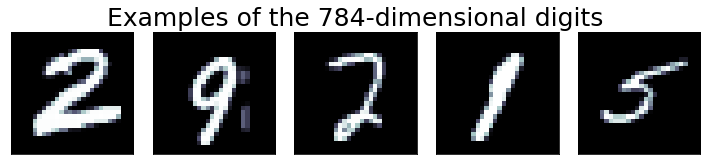

In [5]:
fig,ax=pl.subplots(
    figsize=(10,2),nrows=1,
    ncols=5,sharex=True,sharey=True)
ax=ax.flatten()
for i in range(5):
    image=x_train[i].reshape(28,28)
    ax[i].imshow(image,cmap=pl.cm.bone)
ax[0].set_xticks([]); ax[0].set_yticks([])
pl.tight_layout(); pl.gcf()
ax[2].set_title(
    'Examples of the 784-dimensional digits',fontsize=25);

## CNN Like Models

In [6]:
def model():
    model=tf.keras.Sequential()
    model.add(tkl.Input(shape=(28,28,1)))
    model.add(tkl.BatchNormalization())  
    model.add(tkl.Conv2D(28,(5,5),padding='same'))
    model.add(tkl.LeakyReLU(alpha=.02))
    model.add(tkl.MaxPooling2D(pool_size=(2,2)))
    model.add(tkl.Dropout(.2))   
    model.add(tkl.Conv2D(96,(5,5),padding='same'))
    model.add(tkl.LeakyReLU(alpha=.02))
    model.add(tkl.MaxPooling2D(strides=(2,2)))
    model.add(tkl.Dropout(.2))
    model.add(tkl.Conv2D(128,(5,5)))
    model.add(tkl.LeakyReLU(alpha=.02))
    model.add(tkl.MaxPooling2D(strides=(2,2)))
    model.add(tkl.Dropout(.2)) 
    model.add(tkl.GlobalMaxPooling2D())
    model.add(tkl.Dense(1024))
    model.add(tkl.LeakyReLU(alpha=.02))
    model.add(tkl.Dropout(.5))  
    model.add(tkl.Dense(num_classes,activation='softmax'))        
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='nadam',
                  metrics=['sparse_categorical_accuracy'])
    return model

In [7]:
cnn_model=model()
checkpointer=tkc.ModelCheckpoint(
    filepath='/tmp/checkpoint',verbose=2,save_weights_only=True,
    monitor='val_sparse_categorical_accuracy',mode='max',save_best_only=True)
lr_reduction=tkc.ReduceLROnPlateau(
    monitor='val_loss',patience=15,verbose=2,factor=.8)
early_stopping=tkc.EarlyStopping(
    monitor='val_loss',patience=75,verbose=2)
history=cnn_model.fit(
    x_train,y_train,epochs=120,batch_size=128,
    verbose=2,validation_data=(x_valid,y_valid),
    callbacks=[checkpointer,lr_reduction,early_stopping])

2021-10-30 22:45:59.403499: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-30 22:45:59.490217: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-30 22:45:59.490894: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-30 22:45:59.492496: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/120


2021-10-30 22:46:04.008532: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


263/263 - 9s - loss: 0.3432 - sparse_categorical_accuracy: 0.8873 - val_loss: 0.0691 - val_sparse_categorical_accuracy: 0.9814

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.98143, saving model to /tmp/checkpoint
Epoch 2/120
263/263 - 2s - loss: 0.0770 - sparse_categorical_accuracy: 0.9769 - val_loss: 0.0379 - val_sparse_categorical_accuracy: 0.9890

Epoch 00002: val_sparse_categorical_accuracy improved from 0.98143 to 0.98905, saving model to /tmp/checkpoint
Epoch 3/120
263/263 - 2s - loss: 0.0547 - sparse_categorical_accuracy: 0.9839 - val_loss: 0.0646 - val_sparse_categorical_accuracy: 0.9807

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.98905
Epoch 4/120
263/263 - 2s - loss: 0.0424 - sparse_categorical_accuracy: 0.9865 - val_loss: 0.0423 - val_sparse_categorical_accuracy: 0.9876

Epoch 00004: val_sparse_categorical_accuracy did not improve from 0.98905
Epoch 5/120
263/263 - 2s - loss: 0.0348 - sparse_categorical_accuracy: 0.9893 - val_l

In [8]:
def history_plot(history):
    pl.figure(figsize=(12,5))
    pl.plot(history.history['sparse_categorical_accuracy'][3:],
            '-o',label='train')
    pl.plot(history.history['val_sparse_categorical_accuracy'][3:],
            '-o',label='valid')
    pl.legend(); pl.title('CNN Accuracy'); pl.show()

In [9]:
cnn_model.load_weights('/tmp/checkpoint')
scores=cnn_model.evaluate(x_test,y_test,verbose=0)

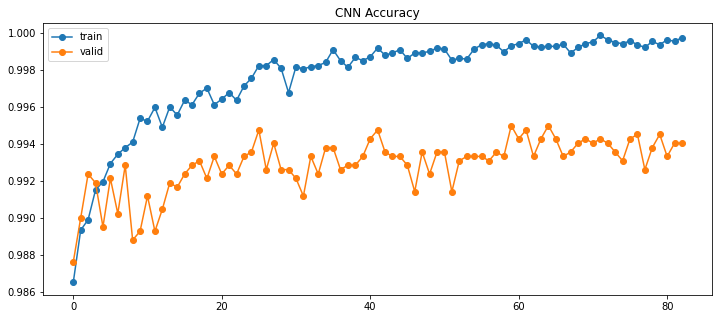

CNN Scores:  [0.02699011191725731, 0.9942857027053833]
CNN Error: 0.57%


In [10]:
history_plot(history)
print('CNN Scores: ',(scores))
print('CNN Error: %.2f%%'%(100-scores[1]*100))

In [11]:
steps,epochs=int(len(x_train)/128),10
datagen=ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    zoom_range=.2,shear_range=.2,rotation_range=30,
    height_shift_range=.2,width_shift_range=.2)
datagen.fit(x_train)
history=cnn_model.\
fit(datagen.flow(x_train,y_train,batch_size=128),
    steps_per_epoch=steps,epochs=epochs,verbose=2,
    validation_data=datagen.flow(x_valid,y_valid,batch_size=16), 
    callbacks=[checkpointer,lr_reduction,early_stopping])

Epoch 1/10
262/262 - 13s - loss: 0.4239 - sparse_categorical_accuracy: 0.8739 - val_loss: 0.1597 - val_sparse_categorical_accuracy: 0.9519

Epoch 00001: val_sparse_categorical_accuracy did not improve from 0.99500
Epoch 2/10
262/262 - 12s - loss: 0.2170 - sparse_categorical_accuracy: 0.9349 - val_loss: 0.1262 - val_sparse_categorical_accuracy: 0.9669

Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.99500
Epoch 3/10
262/262 - 12s - loss: 0.1756 - sparse_categorical_accuracy: 0.9462 - val_loss: 0.1197 - val_sparse_categorical_accuracy: 0.9657

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.99500
Epoch 4/10
262/262 - 12s - loss: 0.1619 - sparse_categorical_accuracy: 0.9514 - val_loss: 0.0893 - val_sparse_categorical_accuracy: 0.9724

Epoch 00004: val_sparse_categorical_accuracy did not improve from 0.99500
Epoch 5/10
262/262 - 12s - loss: 0.1386 - sparse_categorical_accuracy: 0.9581 - val_loss: 0.0839 - val_sparse_categorical_accuracy: 0.9740

Epoc

In [12]:
cnn_model.load_weights('/tmp/checkpoint')
scores=cnn_model.evaluate(x_test,y_test,verbose=0)

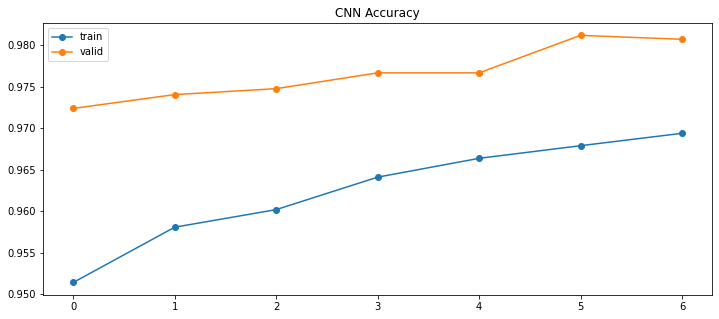

CNN Scores:  [0.02699011191725731, 0.9942857027053833]
CNN Error: 0.57%


In [13]:
history_plot(history)
print('CNN Scores: ',(scores))
print('CNN Error: %.2f%%'%(100-scores[1]*100))

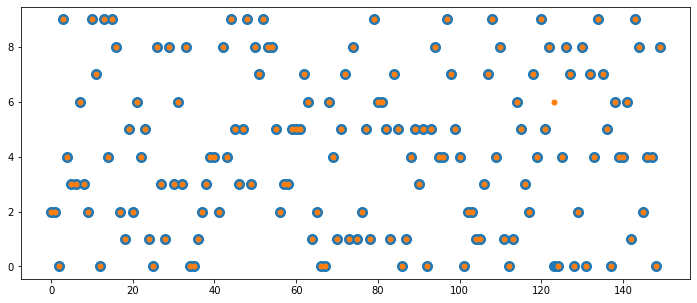

In [14]:
y_test_predictions=\
cnn_model.predict(x_test).argmax(axis=-1)
pl.figure(figsize=(12,5))
pl.scatter(range(150),y_test[:150],s=100)
pl.scatter(range(150),y_test_predictions[:150],s=25);

In [15]:
predict_y_test_out=cnn_model.predict(x_test_out)
predict_y_test_out=predict_y_test_out.argmax(axis=-1)

In [16]:
submission=pd.DataFrame(
    {'ImageId':range(1,len(predict_y_test_out)+1), 
     'Label':predict_y_test_out})
print(submission[0:15].T)
submission.to_csv('kaggle_digits_cnn.csv',index=False)

         0   1   2   3   4   5   6   7   8   9   10  11  12  13  14
ImageId   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15
Label     2   0   9   9   3   7   0   3   0   3   5   7   4   0   4


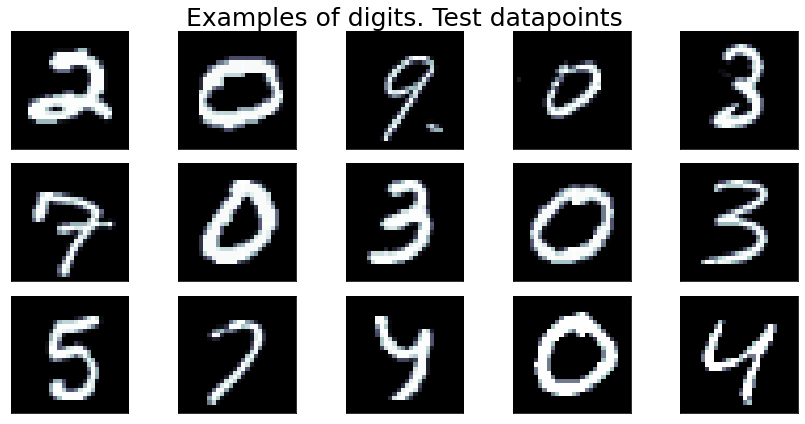

In [17]:
fig,ax=pl.subplots(figsize=(12,6),nrows=3,ncols=5,sharex=True,sharey=True)
ax=ax.flatten()
for i in range(15):
    image=x_test_out[i].reshape(28,28)
    ax[i].imshow(image,cmap=pl.cm.bone)
ax[0].set_xticks([]); ax[0].set_yticks([])
ax[2].set_title('Examples of digits. Test datapoints',fontsize=25)
pl.tight_layout(); pl.gcf(); pl.show()

## Hub Models

In [18]:
N3=10000; n3=int(.1*N3)
x_train3=x_train[:N3]; y_train3=y_train[:N3]
x_valid3=x_valid[:n3]; y_valid3=y_valid[:n3]
x_test3=x_test[:n3]; y_test3=y_test[:n3]
x_train3=tf.repeat(x_train3,3,axis=3).numpy()
x_valid3=tf.repeat(x_valid3,3,axis=3).numpy()
x_test3=tf.repeat(x_test3,3,axis=3).numpy()
x_test3.shape

(1000, 28, 28, 3)

In [19]:
x_train3=tf.image.resize(x_train3,[img_size,img_size]).numpy()
x_valid3=tf.image.resize(x_valid3,[img_size,img_size]).numpy()
x_test3=tf.image.resize(x_test3,[img_size,img_size]).numpy()
x_test3.shape

2021-10-30 22:51:58.887557: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1105920000 exceeds 10% of free system memory.


(1000, 96, 96, 3)

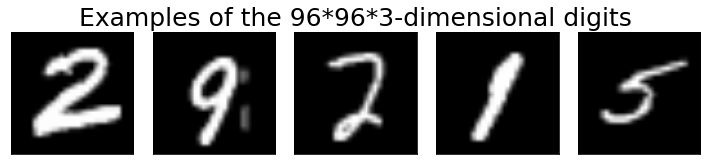

In [20]:
fig,ax=pl.subplots(
    figsize=(10,2),nrows=1,
    ncols=5,sharex=True,sharey=True)
ax=ax.flatten()
for i in range(5):
    img=np.clip(x_train3[i],0,1)
    ax[i].imshow(img)
ax[0].set_xticks([]); ax[0].set_yticks([])
pl.tight_layout(); pl.gcf()
ax[2].set_title(
    f'Examples of the {img_size}*{img_size}*3-dimensional digits',
    fontsize=25);

In [21]:
def premodel(pix,den,mh,lbl,activ,loss):
    model=tf.keras.Sequential([
        tkl.Input((pix,pix,3),name='input'),
        th.KerasLayer(mh,trainable=True),
        tkl.Flatten(),
        tkl.Dense(den,activation='relu'),
        tkl.Dropout(rate=.5),
        tkl.Dense(lbl,activation=activ)])
    model.compile(optimizer='nadam',loss=loss,
                  metrics=['sparse_categorical_accuracy'])
    return model
def cb(fw):
    early_stopping=tkc.EarlyStopping(
        monitor='val_loss',patience=10,verbose=2)
    checkpointer=tkc.ModelCheckpoint(
        filepath=fw,verbose=2,save_weights_only=True,
        monitor='val_sparse_categorical_accuracy',
        mode='max',save_best_only=True)
    lr_reduction=tkc.ReduceLROnPlateau(
        monitor='val_loss',verbose=2,patience=5,factor=.8)
    return [checkpointer,early_stopping,lr_reduction]

In [22]:
fw='/tmp/checkpoint'
handle_base='mobilenet_v2_100_%d'%img_size
mhandle='https://tfhub.dev/google/imagenet/{}/classification/4'\
.format(handle_base)
hub_model=premodel(img_size,1024,mhandle,num_classes,
                  'softmax','sparse_categorical_crossentropy')
history=hub_model.fit(x=x_train3,y=y_train3,batch_size=128,
                      epochs=20,callbacks=cb(fw),verbose=0,
                      validation_data=(x_valid3,y_valid3))

2021-10-30 22:52:05.264530: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1105920000 exceeds 10% of free system memory.
2021-10-30 22:52:06.390005: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1105920000 exceeds 10% of free system memory.



Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.11200, saving model to /tmp/checkpoint

Epoch 00002: val_sparse_categorical_accuracy improved from 0.11200 to 0.63800, saving model to /tmp/checkpoint

Epoch 00003: val_sparse_categorical_accuracy improved from 0.63800 to 0.72200, saving model to /tmp/checkpoint

Epoch 00004: val_sparse_categorical_accuracy improved from 0.72200 to 0.92400, saving model to /tmp/checkpoint

Epoch 00005: val_sparse_categorical_accuracy did not improve from 0.92400

Epoch 00006: val_sparse_categorical_accuracy did not improve from 0.92400

Epoch 00007: val_sparse_categorical_accuracy improved from 0.92400 to 0.97700, saving model to /tmp/checkpoint

Epoch 00008: val_sparse_categorical_accuracy did not improve from 0.97700

Epoch 00009: val_sparse_categorical_accuracy did not improve from 0.97700

Epoch 00010: val_sparse_categorical_accuracy improved from 0.97700 to 0.98800, saving model to /tmp/checkpoint

Epoch 00011: val_sparse_catego

In [23]:
hub_model.load_weights('/tmp/checkpoint')
hub_model.evaluate(x_test3,y_test3,verbose=0)

[0.1494002789258957, 0.9900000095367432]